In [ ]:
# Import the libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['axes.unicode_minus'] = False # Solve the problem of negative sign '-' display
import akshare as ak
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Input A-share CIS300 data from 2005-01-01 to 2025-08-01
index_code = 'sh000300'
start_date = pd.to_datetime('2005-01-01')
end_date = pd.to_datetime('2025-06-30')

price_df = ak.stock_zh_index_daily_tx(symbol=index_code)
price_df['date'] = pd.to_datetime(price_df['date'])
price_df = price_df[(price_df['date'] >= start_date) & (price_df['date'] <= end_date)]
price_df = price_df.sort_values(by='date').set_index('date')
price_df

  0%|          | 0/21 [00:00<?, ?it/s]

,open,close,high,low,amount
date,,,,,
2005-01-04,994.77,982.79,994.77,980.66,7412869.0
2005-01-05,981.58,992.56,997.32,979.88,7119109.0
2005-01-06,993.33,983.17,993.79,980.33,6288029.0
2005-01-07,983.04,983.96,995.71,979.81,7298694.0
2005-01-10,983.76,993.88,993.96,979.79,5791698.0
...,...,...,...,...,...
2025-06-24,3862.39,3904.03,3914.16,3862.39,163656188.0
2025-06-25,3907.07,3960.07,3963.04,3902.18,187213671.0
2025-06-26,3953.16,3946.02,3964.48,3945.26,165316263.0


In [3]:
# Ranking the volume over the past 40 days
N = 40 # Set the window size
price_df['amount_ranked'] = price_df['amount'].rolling(window=N).apply(lambda x: x.rank().iloc[-1], raw = False)
price_df['normalized_amount_rank'] = (price_df['amount_ranked'] * 2 - (N + 1)) / (N - 1) # Normalize the rank to [-1, 1]
price_df


,open,close,high,low,amount,amount_ranked,normalized_amount_rank
date,,,,,,,
2005-01-04,994.77,982.79,994.77,980.66,7412869.0,NaN,NaN
2005-01-05,981.58,992.56,997.32,979.88,7119109.0,NaN,NaN
2005-01-06,993.33,983.17,993.79,980.33,6288029.0,NaN,NaN
2005-01-07,983.04,983.96,995.71,979.81,7298694.0,NaN,NaN
2005-01-10,983.76,993.88,993.96,979.79,5791698.0,NaN,NaN
...,...,...,...,...,...,...,...
2025-06-24,3862.39,3904.03,3914.16,3862.39,163656188.0,38.0,0.897436
2025-06-25,3907.07,3960.07,3963.04,3902.18,187213671.0,40.0,1.000000
2025-06-26,3953.16,3946.02,3964.48,3945.26,165316263.0,37.0,0.846154


In [5]:
# Ranked amount timing: Buy when normalized rank < -0.5, sell when normalized rank > 0.5

s = 0.5 # Set the threshold

timing_df = pd.DataFrame()
timing_df['Open'] = (price_df['normalized_amount_rank'] > s) * 1
timing_df['Not Timing'] = 1

timing_df

,Open,Not Timing
date,,
2005-01-04,0,1
2005-01-05,0,1
2005-01-06,0,1
2005-01-07,0,1
2005-01-10,0,1
...,...,...
2025-06-24,1,1
2025-06-25,1,1
2025-06-26,1,1


In [7]:
# Calculate daily returns and returns after timing
price_df['daily_return'] = price_df['close'].pct_change().shift(-1).fillna(0)
timing_return = timing_df.mul(price_df['daily_return'], axis=0).dropna()

# Calculate cumulative returns
cumulative_return = (1 + timing_return.fillna(0)).cumprod() - 1
cumulative_return

,Open,Not Timing
date,,
2005-01-04,0.000000,0.009941
2005-01-05,0.000000,0.000387
2005-01-06,0.000000,0.001190
2005-01-07,0.000000,0.011284
2005-01-10,0.000000,0.014601
...,...,...
2025-06-24,7.834167,3.029416
2025-06-25,7.802824,3.015120
2025-06-26,7.748705,2.990435


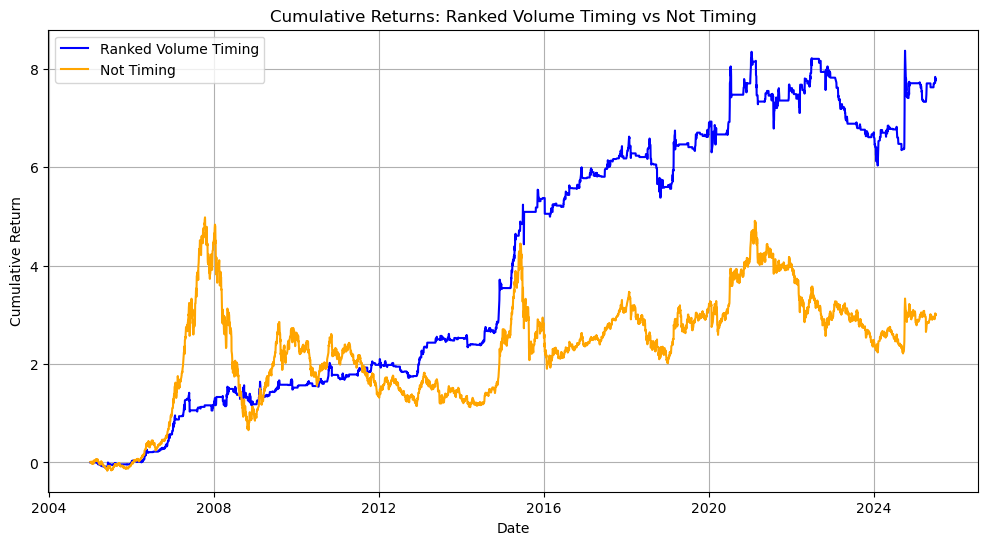

In [8]:
# Visualize the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_return.index, cumulative_return['Open'], label='Ranked Volume Timing', color='blue')
plt.plot(cumulative_return.index, cumulative_return['Not Timing'], label='Not Timing', color='orange')
plt.title('Cumulative Returns: Ranked Volume Timing vs Not Timing')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

In [9]:
# Timing Strategy Based on Different Market Status
# Set the thresholds for different market conditions
bear = 0.6 # bearish
bull = 0 # bullish
v = 0.3 # volatile

days = 10 # Set the number of days for price change
c = 0.05 # Set the price change threshold

# Calculate the price change over the specified number of days
price_df[f'ret_{days}'] = price_df['close'].pct_change(days)
price_df

,open,close,high,low,amount,amount_ranked,normalized_amount_rank,daily_return,ret_10
date,,,,,,,,,
2005-01-04,994.77,982.79,994.77,980.66,7412869.0,NaN,NaN,0.009941,NaN
2005-01-05,981.58,992.56,997.32,979.88,7119109.0,NaN,NaN,-0.009460,NaN
2005-01-06,993.33,983.17,993.79,980.33,6288029.0,NaN,NaN,0.000804,NaN
2005-01-07,983.04,983.96,995.71,979.81,7298694.0,NaN,NaN,0.010082,NaN
2005-01-10,983.76,993.88,993.96,979.79,5791698.0,NaN,NaN,0.003280,NaN
...,...,...,...,...,...,...,...,...,...
2025-06-24,3862.39,3904.03,3914.16,3862.39,163656188.0,38.0,0.897436,0.014354,0.009976
2025-06-25,3907.07,3960.07,3963.04,3902.18,187213671.0,40.0,1.000000,-0.003548,0.016803
2025-06-26,3953.16,3946.02,3964.48,3945.26,165316263.0,37.0,0.846154,-0.006148,0.013828


In [ ]:
'''
price change > c, bullish market
price change < -c, bearish market
else volatile market
'''
# Classify the market status based on the price change
price_df['threshold'] = price_df.loc[:, f'ret_{days}'].apply(lambda x: bull if x > c else (bear if x < -c else v))
price_df

,open,close,high,low,amount,amount_ranked,normalized_amount_rank,daily_return,ret_10,threshold
date,,,,,,,,,,
2005-01-04,994.77,982.79,994.77,980.66,7412869.0,NaN,NaN,0.009941,NaN,0.3
2005-01-05,981.58,992.56,997.32,979.88,7119109.0,NaN,NaN,-0.009460,NaN,0.3
2005-01-06,993.33,983.17,993.79,980.33,6288029.0,NaN,NaN,0.000804,NaN,0.3
2005-01-07,983.04,983.96,995.71,979.81,7298694.0,NaN,NaN,0.010082,NaN,0.3
2005-01-10,983.76,993.88,993.96,979.79,5791698.0,NaN,NaN,0.003280,NaN,0.3
...,...,...,...,...,...,...,...,...,...,...
2025-06-24,3862.39,3904.03,3914.16,3862.39,163656188.0,38.0,0.897436,0.014354,0.009976,0.3
2025-06-25,3907.07,3960.07,3963.04,3902.18,187213671.0,40.0,1.000000,-0.003548,0.016803,0.3
2025-06-26,3953.16,3946.02,3964.48,3945.26,165316263.0,37.0,0.846154,-0.006148,0.013828,0.3


In [16]:
# Get the timing status based on the market condition
timing_df['Timing_Status'] = (price_df['normalized_amount_rank'] > price_df['threshold']).astype(int)

timing_returns = timing_df.mul(price_df['daily_return'], axis=0).dropna()
cumulative_return = (1 + timing_returns.fillna(0)).cumprod() - 1

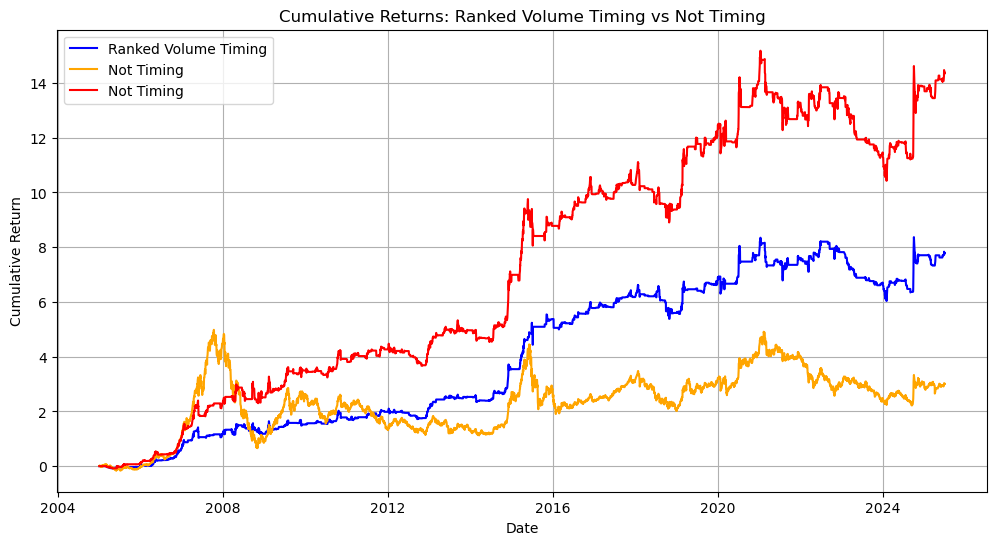

In [17]:
# Visualize the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_return.index, cumulative_return['Open'], label='Ranked Volume Timing', color='blue')
plt.plot(cumulative_return.index, cumulative_return['Not Timing'], label='Not Timing', color='orange')
plt.plot(cumulative_return.index, cumulative_return['Timing_Status'], label='Not Timing', color='Red')
plt.title('Cumulative Returns: Ranked Volume Timing vs Not Timing')
plt.xlabel('Date')
plt.ylabel('Cumulative Return') 
plt.legend()
plt.grid()
plt.show()